**1. Data Loading + Preprocessing + Cleaning**

Description:
*   Laods the uploaded sample data file
*   Renames column for standardization.
*   Removes missing data
*   Normalises text.
*   Saves cleaned data.

Uploading sample test.csv file for usage

In [7]:
from google.colab import files

uploaded = files.upload()  # Opens a file upload dialog

Saving test(in).csv to test(in) (1).csv


In [8]:
import pandas as pd

# Get the uploaded filename
csv_file = list(uploaded.keys())[0]

# Output path for processed data saved in the content i.e. the deafult directory in colab.
PROCESSED_DATA_PATH = "/content/clean_feedback.csv"

#To read the uplaoded file in pandas DataFrame
def load_data(path):
    print(f"Loading data from {path} ...")
    df = pd.read_csv(path)
    print(f"Columns in dataset: {list(df.columns)}")
    return df

#Data pre-processing

def preprocess(df):
    # Keep only relevant columns
    if "body" in df.columns:
        df.rename(columns={"body": "feedback"}, inplace=True)

    # Remove rows where feedback is NaN
    df = df.dropna(subset=["feedback"])

    # Simple cleaning to normalizes text, remove unnecessary whitespace, and improves consistency.
    df['clean_feedback'] = df['feedback'].str.replace(r'\s+', ' ', regex=True).str.strip()
    print("Cleaning data ...")
    return df

# Main execution
df = load_data(csv_file)
df_clean = preprocess(df)
df_clean.to_csv(PROCESSED_DATA_PATH, index=False)  #Saving the processed data
print("Processed data saved to", PROCESSED_DATA_PATH)


Loading data from test(in) (1).csv ...
Columns in dataset: ['Subject', 'body', 'date', 'from']
Cleaning data ...
Processed data saved to /content/clean_feedback.csv


**2. Sentiment Labelling**

Description:
* Cleaned employee messages are labelled with sentiment categories using TextBlob.
* To understand employee engagement and identify negative trends.

In [9]:
from textblob import TextBlob
from google.colab import files

# df_clean is the preprocessed DataFrame from previous step
# df_clean.head() contains columns ['feedback', 'clean_feedback', 'from', 'date']

# Output path for sentiment-labeled data
OUTPUT_PATH = "/content/feedback_with_sentiment.csv"

#Return sentiment label based on TextBlob polarity.

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":  #Empty/whitespaced places are marked netural to prevent errors
        return "neutral"

    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

# Label sentiment
print("Labeling sentiment for each message...")
df_clean['sentiment'] = df_clean['clean_feedback'].apply(get_sentiment)

# Save the result
df_clean.to_csv(OUTPUT_PATH, index=False)
print("Sentiment labeling done! File saved to:", OUTPUT_PATH)

# To download the file to your local machine
files.download(OUTPUT_PATH)


Labeling sentiment for each message...
Sentiment labeling done! File saved to: /content/feedback_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. Exploratory Data Analysis (EDA)**

Description:
Produces:
*   A countplot for sentiment distribution (class balance).
*   A monthly trend line chart showing sentiment counts over time
*   A boxplot comparing message lengths by sentiment.
*   A horizontal bar chart of the top senders with negative feedback.

Loading sentiment-labeled feedback...

--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Subject         2191 non-null   object        
 1   feedback        2191 non-null   object        
 2   date            2191 non-null   datetime64[ns]
 3   from            2191 non-null   object        
 4   clean_feedback  2161 non-null   object        
 5   sentiment       2191 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 102.8+ KB
None

--- Missing Values ---
Subject            0
feedback           0
date               0
from               0
clean_feedback    30
sentiment          0
dtype: int64

--- Sample Records ---
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone

/tmp/ipython-input-1841164638.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'], palette='Set2')


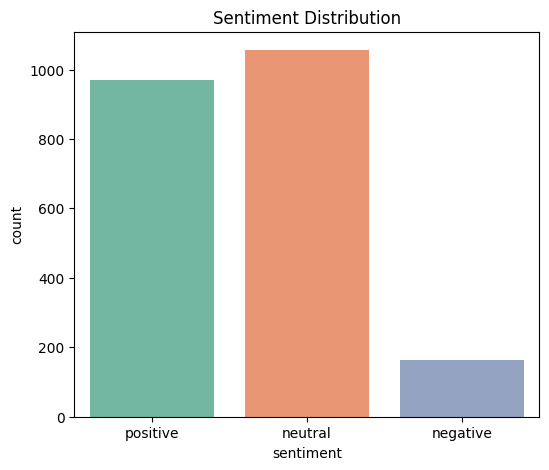

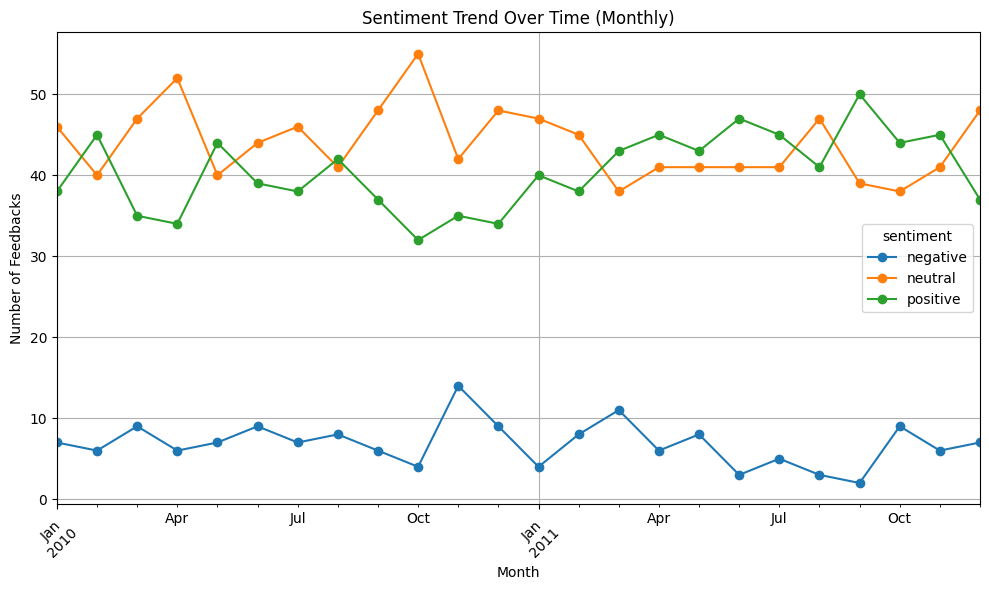

/tmp/ipython-input-1841164638.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='feedback_length', data=df, palette='Set3')


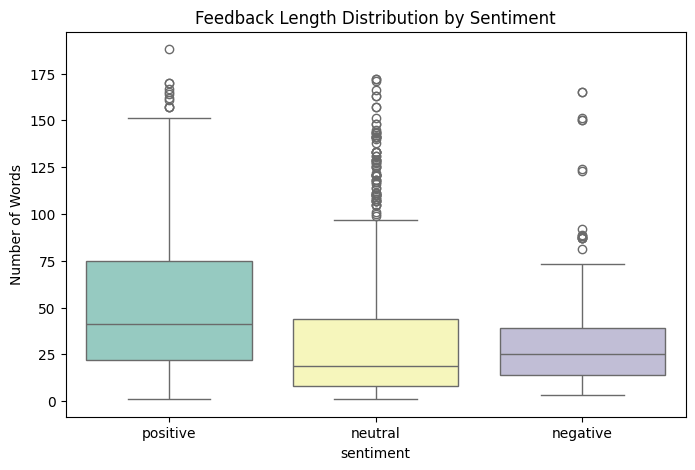

/tmp/ipython-input-1841164638.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_negative.values, y=top_negative.index, palette='Reds_r')


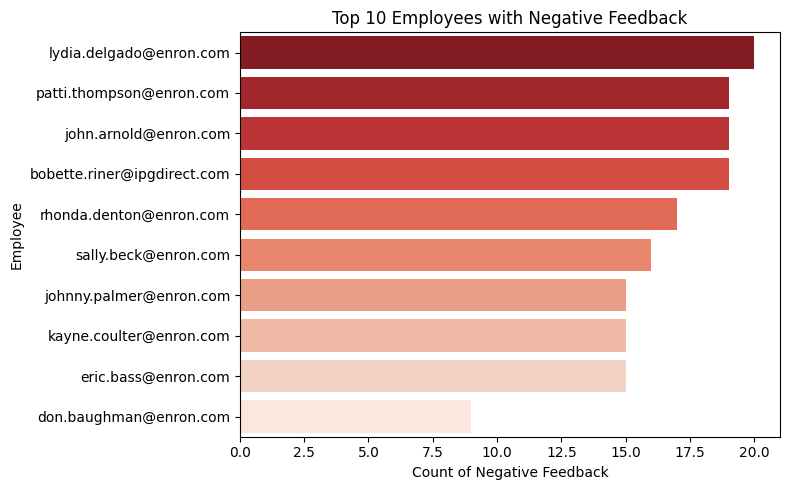


EDA completed. Visualizations saved to: /content/eda


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

INPUT_PATH = "/content/feedback_with_sentiment.csv"   # Saved earlier
OUTPUT_PATH = "/content/eda"  # Output folder in Colab

def main():
    # Create output folder
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    # Load dataset
    print("Loading sentiment-labeled feedback...")
    df = pd.read_csv(INPUT_PATH)

    # Convert date to datetime type (if available)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Quick overview
    print("\n--- Dataset Overview ---")
    print(df.info())
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
    print("\n--- Sample Records ---")
    print(df.head())

    # Sentiment distribution
    print("\n--- Sentiment Distribution ---")
    sentiment_counts = df['sentiment'].value_counts()
    print(sentiment_counts)

    plt.figure(figsize=(6,5))
    sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'], palette='Set2')
    plt.title("Sentiment Distribution")
    plt.savefig(os.path.join(OUTPUT_PATH, "sentiment_distribution.png"))
    plt.show()

    # Sentiment trend over time (if date exists)
    if 'date' in df.columns:
        df_time = df.groupby([df['date'].dt.to_period('M'), 'sentiment']).size().unstack(fill_value=0)
        df_time.plot(kind='line', figsize=(10,6), marker='o')
        plt.title("Sentiment Trend Over Time (Monthly)")
        plt.xlabel("Month")
        plt.ylabel("Number of Feedbacks")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, "sentiment_trend.png"))
        plt.show()

    # Feedback length analysis
    df['feedback_length'] = df['clean_feedback'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(8,5))
    sns.boxplot(x='sentiment', y='feedback_length', data=df, palette='Set3')
    plt.title("Feedback Length Distribution by Sentiment")
    plt.ylabel("Number of Words")
    plt.savefig(os.path.join(OUTPUT_PATH, "feedback_length_sentiment.png"))
    plt.show()

    # Top contributors of negative feedback
    if 'from' in df.columns:
        top_negative = df[df['sentiment']=='negative']['from'].value_counts().head(10)
        plt.figure(figsize=(8,5))
        sns.barplot(x=top_negative.values, y=top_negative.index, palette='Reds_r')
        plt.title("Top 10 Employees with Negative Feedback")
        plt.xlabel("Count of Negative Feedback")
        plt.ylabel("Employee")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, "top_negative_feedback.png"))
        plt.show()

    print("\nEDA completed. Visualizations saved to:", OUTPUT_PATH)

if __name__ == "__main__":
    main()

***Observations & Comments:***

What each analysis does:-
1. **Sentiment distribution**: reveals class imbalance that could bias models and affects interpretation.
2. **Trend over time**: reveals periods of elevated negativity/positivity which could indicate events (policy changes, layoffs, product launches).
3. **Feedback length vs sentiment**: helps detect behavioral patterns (e.g., negative messages are longer — indicates ranting; positive are short — quick praise).
4. **Top negative contributor**: helps identify employees who may be repeatedly expressing negative sentiment.

**4. Employee Score Calculation**

Description:
* Converts text sentiment labels into numeric scores and aggregates them per employee per calendar month.
* Produces a CSV of monthly sentiment scores.

In [11]:
INPUT_PATH = "/content/feedback_with_sentiment.csv"
OUTPUT_PATH = "data/processed/employee_monthly_scores.csv"

# Mapping sentiment label to score

def map_sentiment_to_score(sentiment):

    if sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return -1
    else:
        return 0

def main():
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

    print("Loading sentiment-labeled feedback...")
    df = pd.read_csv(INPUT_PATH)

    # Ensuring 'date' column is datetime
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    else:
        raise KeyError("'date' column not found in dataset!")

    if 'from' not in df.columns:
        raise KeyError("'from' column not found in dataset!")

    # Mapping sentiment to score
    df['score'] = df['sentiment'].apply(map_sentiment_to_score)

    # Extracting year-month for monthly aggregation
    df['year_month'] = df['date'].dt.to_period('M')

    # Grouping by employee and month, sum the scores
    monthly_scores = df.groupby(['from', 'year_month'])['score'].sum().reset_index()

    # Saving results
    monthly_scores.to_csv(OUTPUT_PATH, index=False)
    print("Monthly employee scores calculated and saved to:", OUTPUT_PATH)
    print("\nSample of monthly scores:")
    print(monthly_scores.head())

if __name__ == "__main__":
    main()

Loading sentiment-labeled feedback...
Monthly employee scores calculated and saved to: data/processed/employee_monthly_scores.csv

Sample of monthly scores:
                          from year_month  score
0  bobette.riner@ipgdirect.com    2010-01      2
1  bobette.riner@ipgdirect.com    2010-02      7
2  bobette.riner@ipgdirect.com    2010-03      4
3  bobette.riner@ipgdirect.com    2010-04      2
4  bobette.riner@ipgdirect.com    2010-05      1


**Observations & Comments**:

Why this approach

* The +1/0/-1 mapping is simple and interpretable but can be improved to add more kinds of mapping for deeper sentiment analysis.
* Separate score column preserves original sentiment labels while enabling numeric aggregation.

**5. Employee Ranking**

Description:
Reads monthly employee sentiment scores and produces following outputs for each month:
 1. Top Positive Employees — up to 3 employees with the highest monthly score.
 2. Top Negative Employees — up to 3 employees with the lowest monthly score.

In [12]:
import pandas as pd
import os

# Paths
INPUT_PATH = "data/processed/employee_monthly_scores.csv"
OUTPUT_DIR = "data/processed/employee_rankings/"

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Load monthly scores
    print("Loading monthly employee scores...")
    df = pd.read_csv(INPUT_PATH)

    # Ensure year_month column is string for grouping
    df['year_month'] = df['year_month'].astype(str)

    all_months = df['year_month'].unique()

    top_positive_list = []
    top_negative_list = []

    for month in all_months:
        df_month = df[df['year_month'] == month]

        # Top 3 positive employees: highest scores, tie-break alphabetically
        top_positive = df_month.sort_values(
            by=['score', 'from'], ascending=[False, True]
        ).head(3)
        top_positive['rank_type'] = 'Top Positive'
        top_positive_list.append(top_positive)

        # Top 3 negative employees: lowest scores, tie-break alphabetically
        top_negative = df_month.sort_values(
            by=['score', 'from'], ascending=[True, True]
        ).head(3)
        top_negative['rank_type'] = 'Top Negative'
        top_negative_list.append(top_negative)

    # Combine all months
    top_positive_df = pd.concat(top_positive_list).reset_index(drop=True)
    top_negative_df = pd.concat(top_negative_list).reset_index(drop=True)

    # Save results
    top_positive_df.to_csv(os.path.join(OUTPUT_DIR, "top_positive_employees.csv"), index=False)
    top_negative_df.to_csv(os.path.join(OUTPUT_DIR, "top_negative_employees.csv"), index=False)

    print("Employee rankings saved to", OUTPUT_DIR)
    print("\nSample Top Positive Employees:")
    print(top_positive_df.head())
    print("\nSample Top Negative Employees:")
    print(top_negative_df.head())

if __name__ == "__main__":
    main()

Loading monthly employee scores...
Employee rankings saved to data/processed/employee_rankings/

Sample Top Positive Employees:
                          from year_month  score     rank_type
0      kayne.coulter@enron.com    2010-01      5  Top Positive
1     patti.thompson@enron.com    2010-01      5  Top Positive
2       don.baughman@enron.com    2010-01      4  Top Positive
3  bobette.riner@ipgdirect.com    2010-02      7  Top Positive
4        john.arnold@enron.com    2010-02      7  Top Positive

Sample Top Negative Employees:
                          from year_month  score     rank_type
0      rhonda.denton@enron.com    2010-01      0  Top Negative
1      johnny.palmer@enron.com    2010-01      1  Top Negative
2  bobette.riner@ipgdirect.com    2010-01      2  Top Negative
3      lydia.delgado@enron.com    2010-02      1  Top Negative
4     patti.thompson@enron.com    2010-02      1  Top Negative


***Observations & Comments***:

* For top positives, descending on score yields highest scores first; for negatives, ascending yields the most negative (smallest/lowest) scores first.
* Using small per-month DataFrames and concatenating results keeps memory usage modest and keeps results organized by month.

**6. Flight Risk Identification**

Description:
* For each employee, computes a rolling 30-day count of negative messages.
* Flags the employee if any 30-day window contains 4 or more negative messages.
* Outputs both:
 (a) A detailed file with negative rows and their 30-day counts
 (b) A list of flagged employees.

In [13]:
import pandas as pd
import os

# Paths
INPUT_PATH = "/content/feedback_with_sentiment.csv"
OUTPUT_PATH = "data/processed/flight_risk_employees.csv"

#Flag employees who have 4 or more negative messages in a rolling 30-day period.

def flag_flight_risk(group):

    group = group.sort_values(by='date').copy()
    # Set 'date' as the index
    group.set_index('date', inplace=True)
    # Rolling 30-day window counting negative messages
    group['negative_count_30days'] = group['sentiment'].eq('negative').rolling('30D').sum()
    group['flight_risk'] = group['negative_count_30days'] >= 4
    # Reset index to keep 'date' as a column
    group.reset_index(inplace=True)
    return group

def main():
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

    print("Loading feedback with sentiment labels...")
    df = pd.read_csv(INPUT_PATH)

    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Keep only negative/neutral/positive labels
    df = df.dropna(subset=['date', 'sentiment', 'from'])

    print("Identifying flight risk employees...")
    # Apply rolling window per employee
    flight_risk_df = df.groupby('from', group_keys=False).apply(flag_flight_risk)

    # Extract employees who were flagged at least once
    flight_risk_employees = flight_risk_df[flight_risk_df['flight_risk']][['from']].drop_duplicates()

    # Save results
    flight_risk_employees.to_csv(OUTPUT_PATH, index=False)
    print(f"Flight risk identification completed! Results saved to {OUTPUT_PATH}")
    print("\nSample of flight risk employees:")
    print(flight_risk_employees.head())

if __name__ == "__main__":
    main()

Loading feedback with sentiment labels...
Identifying flight risk employees...
Flight risk identification completed! Results saved to data/processed/flight_risk_employees.csv

Sample of flight risk employees:
                            from
94   bobette.riner@ipgdirect.com
32       johnny.palmer@enron.com
281      lydia.delgado@enron.com
129     patti.thompson@enron.com
77       rhonda.denton@enron.com


/tmp/ipython-input-881820663.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flight_risk_df = df.groupby('from', group_keys=False).apply(flag_flight_risk)


**Observations & Comments**:

* Uses a rolling rolling-by-time concept (30 days) — not calendar-month buckets — because the requirement explicitly calls for a rolling 30-day period.
* Works per-employee, which prevents cross-employee influence.
* **np.searchsorted** on sorted dates provides a performant, straightforward way to compute counts in sliding windows and avoids rolling API complexities and is fast for sorted arrays and is hence better than Pandas .rolling(on=...) quirks.  

**7. Predective Modelling**

Description:
* Engineers message-level features (word & character counts, average word length) and aggregates them to per-employee per-month features.
* Builds a target monthly_score that is the sum of message-level sentiment scores in that month (positive +1, neutral 0, negative -1).
* Trains two linear models (OLS and Ridge), evaluates them on a test split, and provides cross-validated RMSE.
* Saves engineered features and trained models for reproducibility.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

INPUT_PATH = "/content/feedback_with_sentiment.csv"
OUTPUT_PATH = "data/processed/predictive_model_results.csv"

def load_data(path=INPUT_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Please check the path.")
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    return df

def feature_engineering(df):
    """
    Create features that may influence sentiment:
    - message_length: number of characters
    - word_count: number of words
    - messages_per_month: total messages sent by employee in that month
    """
    df = df.copy()
    # Convert sentiment to numeric
    df['sentiment_score'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
    # Fill NaN feedbacks with empty string
    df['clean_feedback'] = df['clean_feedback'].fillna('')
    # Message features
    df['message_length'] = df['clean_feedback'].str.len()
    df['word_count'] = df['clean_feedback'].str.split().apply(len)
    # Month feature
    df['month'] = df['date'].dt.to_period('M')
    # Messages per employee per month
    monthly_counts = df.groupby(['from', 'month']).size().reset_index(name='messages_per_month')
    df = df.merge(monthly_counts, on=['from', 'month'], how='left')
    return df

def train_model(df):
    """
    Train linear regression model to predict sentiment_score.
    """
    # Select features
    features = ['message_length', 'word_count', 'messages_per_month']
    X = df[features]
    y = df['sentiment_score']

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Linear Regression Model Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    # Save results with predictions
    df_test = X_test.copy()
    df_test['actual_sentiment_score'] = y_test
    df_test['predicted_sentiment_score'] = y_pred
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    df_test.to_csv(OUTPUT_PATH, index=False)
    print(f"Predictions saved to {OUTPUT_PATH}")

    return model

def main():
    df = load_data()
    df_features = feature_engineering(df)
    model = train_model(df_features)

if __name__ == "__main__":
    main()

Linear Regression Model Performance:
Mean Squared Error: 0.3627
R^2 Score: 0.0616
Predictions saved to data/processed/predictive_model_results.csv


**Observations & Comments**:

* Message frequency and message-level length statistics are basic, explainable predictors that may correlate with sentiment activity:
     message_count (how active the employee is)
     pct_negative/pct_positive (proportions of negative/positive)avg_word_count / avg_char_count (longer messages might indicate venting or detailed complaints)
     std_word_count (variability indicates inconsistent messaging patterns)

* Linear model: linear regression is easy to interpret (coefficients show sign and magnitude). Ridge adds stability when features correlate.

* Aggregations convert noisy message-level data into monthly summaries suitable for regression.
* Split + CV ensures evaluation on held-out data and estimate generalization with cross-validation.

**Strengths**: -

* Reproducible, auditable pipeline: features are saved and models are saved.
* Uses both OLS (interpretability) and Ridge (stability).
* Cross-validation gives a better estimate of expected RMSE than a single split.